In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pandas as pd
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as f
# from torchsummary import summary
import torch.optim as optim

from torchvision import models, transforms
import torchvision

import numpy as np
import os
import random

from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from PIL import Image

from keras.datasets import mnist

In [43]:
class MNISTDataset(torch.utils.data.Dataset):

  def __init__(self,
               hr_dims=(48,48),
               scale_factor=4,
               train=True):

        (train_x, _), (val_x, _) = mnist.load_data()
        if train:
            self.images = train_x
        else:
            self.images = val_x

        hr_height, hr_width = hr_dims
        scale_factor = scale_factor

        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height//scale_factor, hr_height//scale_factor), Image.BICUBIC),
                transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5,), std=(0.5,))
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5,), std=(0.5,))
            ]
        )

  def __len__(self):
        return len(self.images)

  def _degrade_resolution(self, image):
        resized = cv2.resize(
            cv2.GaussianBlur(
                image,(3,3),cv2.BORDER_DEFAULT),(7,7))
        return resized

  def plot_sample(self):
        rand_ind = random.randint(0,self.__len__())
        fig, (ax1, ax2) = plt.subplots(1, 2)
        low_res, high_res = self.__getitem__(rand_ind)

        ax1.imshow(low_res.cpu().numpy()[0,...], cmap="gray")
        ax1.set_title("Low resolution")
        ax2.imshow(high_res.cpu().numpy()[0,...], cmap="gray")
        ax2.set_title("High resolution")

        for i in [ax1, ax2]:
            i.xaxis.set_visible(False)
            i.yaxis.set_visible(False) 

        plt.show()

  def __getitem__(self, index):
        # Select sample
        img = Image.fromarray(self.images[index,...])
        low_res = self.lr_transform(img)
        high_res = self.hr_transform(img)

        return low_res.to(device).float(), high_res.to(device).float()

In [44]:
image_dataset = MNISTDataset(scale_factor=8)

dl_train = torch.utils.data.DataLoader(image_dataset,
                                                 shuffle = True,
                                                 batch_size = 32
                                                )

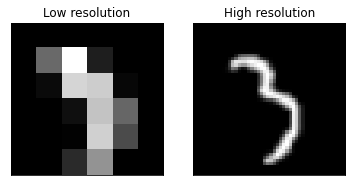

In [45]:
image_dataset.plot_sample()

In [46]:
X, Y = next(iter(dl_train))

In [47]:
X.shape, Y.shape

(torch.Size([32, 1, 6, 6]), torch.Size([32, 1, 48, 48]))

## models

In [64]:
gen = Generator(
    nres=3, nf_in=1, nf=256, use_noise=True, spectral_norm=True
).to(device)

In [65]:
disc = Discriminator(
    nf=256, ndown=4, nres=3, sigmoid=False, spectral_norm=True
).to(device)

In [66]:
count_parameters(gen)/1e6, count_parameters(disc)/1e6

(4.167607, 4.789025)

In [67]:
betas = (0.5, 0.9)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=betas)

In [68]:
X_sample, y_sample = next(iter(dl_train))

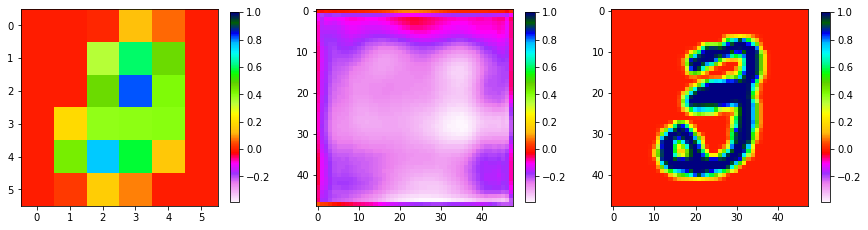

In [69]:
plot_sample(X_sample, y_sample, gen, 0)

## Pretraining

In [56]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [58]:
trainer = Trainer(gen, optimizer, criterion, dl_train)

In [59]:
# trainer.fit(1)

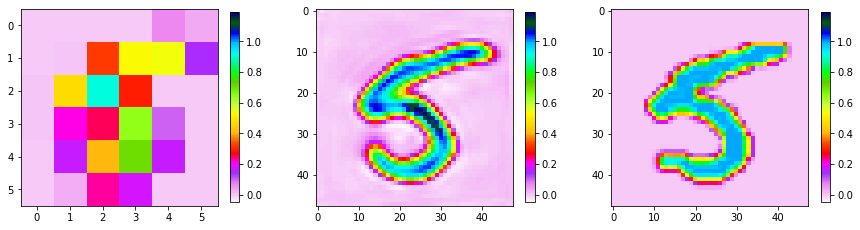

In [60]:
# plot_sample(X_sample, y_sample, gen, 0)

## GAN

In [70]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, disc_repeats=5, l_loss='l1', 
    adv_loss_type='Wasserstein', gp_lambda=10,
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

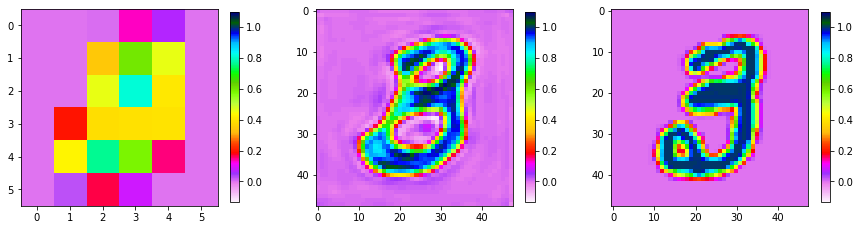

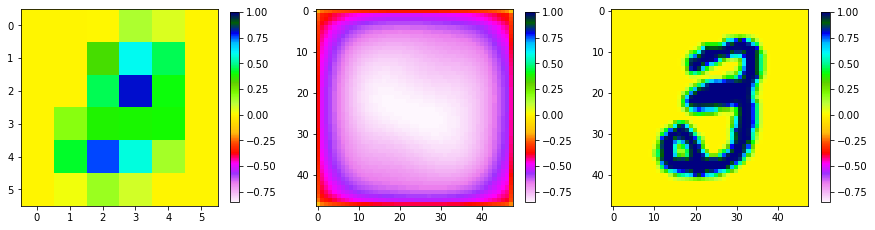

KeyboardInterrupt: 

In [71]:
trainer.fit(10)

Text(0.5, 1.0, 'Disc loss')

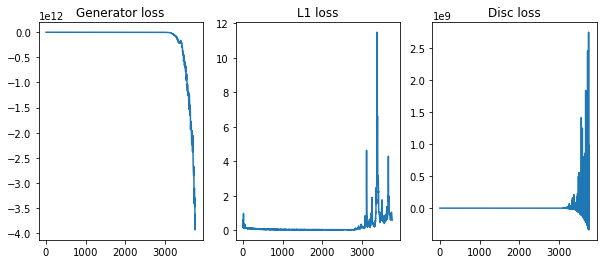

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(trainer.train_gen_losses); ax1.set_title('Generator loss')
ax2.plot(trainer.train_l_losses); ax2.set_title('L1 loss')
ax3.plot(trainer.train_disc_losses); ax3.set_title('Disc loss')